# Plots

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import glob
import os

base_path = 'data'
pattern = os.path.join(base_path, '**', '*_averages.csv')
csv_files = glob.glob(pattern, recursive=True)

dfs = []
for fpath in csv_files:
    
    parts = fpath.split(os.sep)
    
    implementation_name = parts[1]  # if "data" is parts[0]
    
    op_mix_range = parts[2]
    op_mix, range_type = op_mix_range.split('_')  # "101080", "shared" or "404020", "disjoint", etc.
    
    filename = parts[-1]  # "1s_8threads_averages.csv"

    base_name = filename.replace('_averages.csv', '')
    splitted = base_name.split('_')

    runtime_str = splitted[0].rstrip('s')  # remove trailing "s"
    num_threads_str = splitted[1].replace('threads', '')  # remove "threads"
    
    try:
        runtime = int(runtime_str)
    except ValueError:
        runtime = runtime_str 

    df = pd.read_csv(fpath)
    
    # Add columns
    df['implementation_name'] = implementation_name
    df['op_mix'] = op_mix
    df['range_type'] = range_type
    df['runtime_in_sec'] = runtime

    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
display(final_df.head())


,threads,time,total_inserts,successful_inserts,total_deletes,successful_deletes,total_contains,successful_contains,total_operations,implementation_name,op_mix,range_type,runtime_in_sec
0,1,1.000001,247575.0,145273.0,224604.0,93332.0,1776179.0,736764.0,2248358.0,global_lock,101080,shared,1
1,2,1.000002,142919.0,93620.0,128989.0,44576.0,1018305.0,352295.0,1290213.0,global_lock,101080,shared,1
2,4,1.000004,77965.0,58468.0,69760.0,17749.0,551687.0,139226.0,699412.0,global_lock,101080,shared,1
3,8,1.000017,86996.0,63594.0,78572.0,21060.0,620300.0,168169.0,785868.0,global_lock,101080,shared,1
4,10,1.000021,83751.0,61768.0,75027.0,19833.0,596448.0,157554.0,755226.0,global_lock,101080,shared,1


/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_13933/1647683959.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


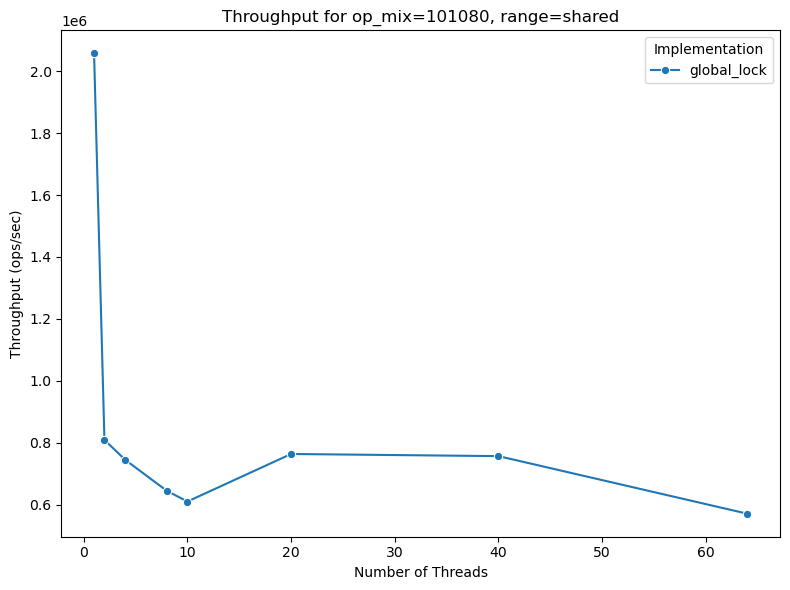

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_101080_shared = final_df.loc[
    (final_df['op_mix'] == '404020') & 
    (final_df['range_type'] == 'shared')
].copy()

df_101080_shared['throughput'] = df_101080_shared['total_operations'] / df_101080_shared['time']

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df_101080_shared, 
    x='threads', 
    y='throughput', 
    hue='implementation_name', 
    marker='o',
    ci=None  # <--- Add this
)

plt.title("Throughput for op_mix=101080, range=shared")
plt.xlabel("Number of Threads")
plt.ylabel("Throughput (ops/sec)")
plt.legend(title="Implementation")
plt.tight_layout()
plt.show()

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_13933/1163861273.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


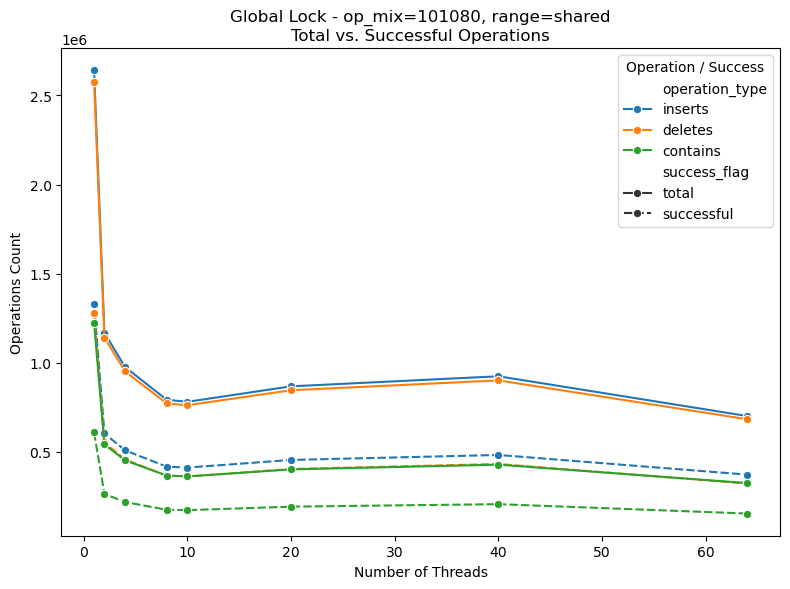

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = final_df[
    (final_df['implementation_name'] == 'global_lock') &
    (final_df['op_mix'] == '404020') &
    (final_df['range_type'] == 'shared')
].copy()

df_melted = df_filtered.melt(
    id_vars=['threads'],  # columns to keep
    value_vars=[
        'total_inserts', 'successful_inserts',
        'total_deletes', 'successful_deletes',
        'total_contains', 'successful_contains'
    ],
    var_name='metric',     # name of the new "melted" column
    value_name='count'     # name of the new column holding values
)

def parse_metric(metric_name):
    """
    Example input: 'total_inserts' or 'successful_deletes'
    Returns       operation_type, success_flag
    """
    if metric_name.startswith('total_'):
        success_flag = 'total'
        op_type = metric_name.replace('total_', '')
    else:
        success_flag = 'successful'
        op_type = metric_name.replace('successful_', '')
    return pd.Series([op_type, success_flag])

df_melted[['operation_type','success_flag']] = df_melted['metric'].apply(parse_metric)

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df_melted,
    x='threads',
    y='count',
    hue='operation_type',   # inserts, deletes, contains
    style='success_flag',   # total vs. successful
    marker='o',
    ci=None  # <--- Add this
)

plt.title("Global Lock - op_mix=101080, range=shared\nTotal vs. Successful Operations")
plt.xlabel("Number of Threads")
plt.ylabel("Operations Count")
plt.legend(title="Operation / Success")
plt.tight_layout()
plt.show()